In [1]:
import pandas as pd
import plotly.express as px

In [8]:
data = pd.read_csv('racial.csv')
data = data.rename(columns={'Non-white Pop': 'Non-white Pop (%)'})
data = data.rename(columns={"Proportion of the City's Population That Has Been Vaccinated": 'Proportion'})
data

,City,Non-white Pop (%),Vaccinated,Total Pop,Vaccinated by Share of Pop,Proportion
0,Agoura Hills,26,3406,20883,6,0.163099
1,Alhambra,91,11941,86724,7,0.137690
2,Arcadia,78,9674,57754,6,0.167504
3,Artesia,85,2521,16795,7,0.150104
4,Avalon,57,250,3869,15,0.064616
...,...,...,...,...,...,...
81,Walnut,90,5589,30532,5,0.183054
82,West Covina,88,14446,108235,7,0.133469
83,West Hollywood,25,4314,36951,9,0.116749
84,Westlake Village,22,950,8360,9,0.113636


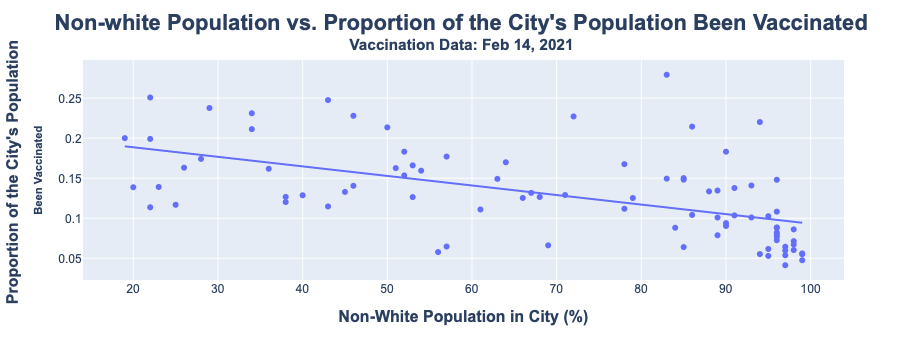

In [15]:
fig = px.scatter(
    data,
    x = "Non-white Pop (%)",
    y = "Proportion",
    trendline="ols",
    hover_name="City",
    hover_data={
        "City": False,
        "Non-white Pop (%)": True,
        "Proportion": True,
    }
)

fig.update_layout(
    xaxis_title="<b>Non-White Population in City (%)</b>",
    yaxis_title="<b>Proportion of the City's Population <br><sub>Been Vaccinated<sub></b>",
    font=dict(family="Arial"),
    title = "<b>Non-white Population vs. Proportion of the City's Population Been Vaccinated<b><br><sup>Vaccination Data: Feb 14, 2021</sup>",
    title_x = 0.5,
    xaxis_title_font=dict(size=16), 
    yaxis_title_font=dict(size=16),
    title_font=dict(size=22)
)
fig.show()
fig.write_html("racial_plot.html")

In [11]:
import matplotlib.pyplot as plt
data_overall = pd.read_csv("racial_overall.csv")
data_overall

,Racial Group,% of Population (Age 5+) Being Vaccinated
0,Black/African American,61%
1,Latinx,64%
2,White,79%
3,American Indian/Alaska Native,83%
4,Asian,88%
